In [1]:
!pip install sklearn

You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
import datetime as dt
import math
from pylab import rcParams
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'G'

## Split data
- Merge labels and features into one table
- Split data from each city
- Split train and validation tables


In [3]:
train_split_size = 0.75

labels = pd.read_csv('../data/dengue_labels_train.csv')
features = pd.read_csv('../data/dengue_features_train.csv')
df = labels.merge(features)

sj_data = df[df.city == 'sj']
iq_data = df[df.city == 'iq']

sj_data = sj_data.reset_index()
iq_data = iq_data.reset_index()


def split(df, train_split_size):
    train_size = int(math.ceil(len(df)*train_split_size))
    val_size = int(math.floor((len(df)*(1-train_split_size))))
    return df[0:train_size], df[train_size:train_size+val_size]


sj_train, sj_val = split(sj_data, train_split_size)
iq_train, iq_val = split(iq_data, train_split_size)

# Model as a Regression

In [65]:
def treat_features(data):
    Y = data['total_cases'].values.reshape(-1, 1)
    data = data.drop(['index', 'total_cases', 'city', 'year', 'week_start_date', 'weekofyear'], axis=1)
    data.fillna(method='ffill', inplace=True)
    X = (data - data.mean()) / (data.max() - data.min())
    X = X.values
    return X, Y


linear_regressor = LinearRegression()  # create object for the class

X, Y = treat_features(sj_train)
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
error = mean_absolute_error(Y, Y_pred)
print("Train MAE = {}".format(error))


X, Y = treat_features(sj_val)  # values converts it into a numpy array
Y_pred = linear_regressor.predict(X)  # make predictions
error = mean_absolute_error(Y, Y_pred)
print("Validation MAE = {}".format(error))

Train MAE = 31.98444408167357
Validation MAE = 29.823997020174605


# Model without exougenous variables

In [56]:
def time_series_analysis(df_train, df_val):
    history = df_train['total_cases']
    val = df_val['total_cases']
    
    # Decomposition for visual analysis
    rcParams['figure.figsize'] = 18, 8
    decomposition = sm.tsa.seasonal_decompose(history, model='additive', freq=52)
    fig = decomposition.plot()
    plt.show()
    
    # Fit a Sarimax Model with 1 year sasonality (cant get 3 years to work)
    mod = sm.tsa.statespace.SARIMAX(history, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52),
                                    enforce_stationarity=False, enforce_invertibility=False)

    results = mod.fit()
    print('AIC:{}'.format(results.aic))
    print(results.summary().tables[1])
    results.plot_diagnostics(figsize=(18, 8))
    plt.show()
    
    # Make a prediction for the validation set and compare with ground truth
    pred_uc = results.get_forecast(steps=len(val))
    pred_ci = pred_uc.conf_int()
    ax = val.plot(label='observed', figsize=(14, 4))
    pred_uc.predicted_mean.plot(label='Forecast')
    ax.fill_between(pred_ci.index[:],
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Registered Cases')
    plt.legend()
    plt.show()

    predictions = pred_uc.predicted_mean.values
    error = mean_absolute_error(val, predictions)
    print('Test MAE: %.3f' % error)

    
    
    

## San Juan

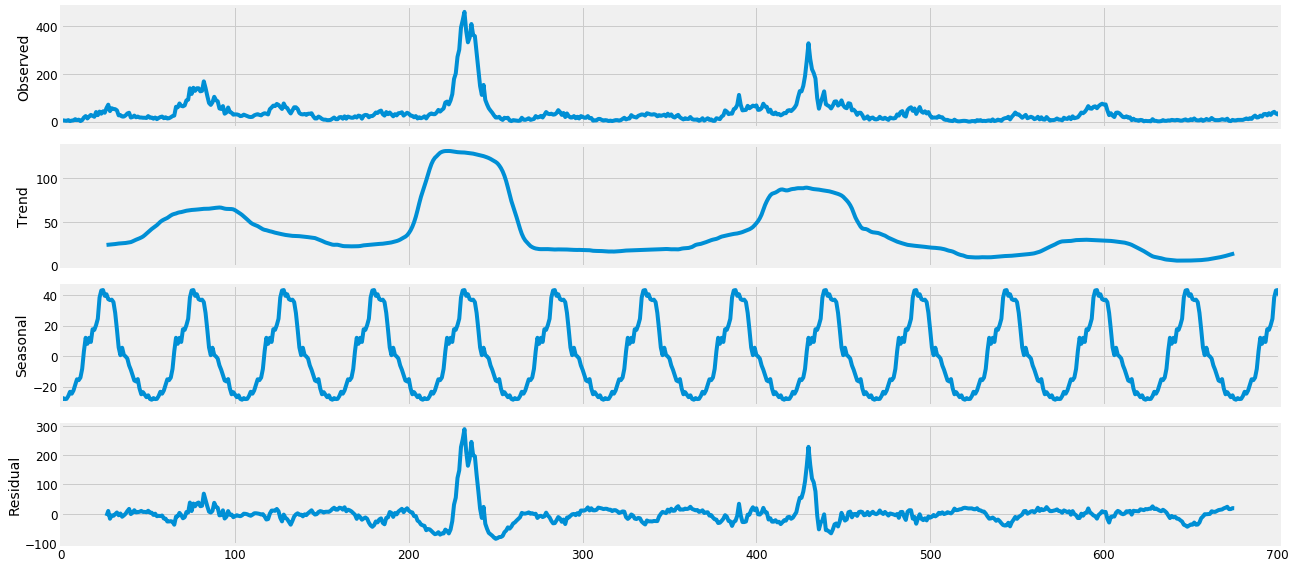

AIC:4967.460351873975
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4400      0.081      5.427      0.000       0.281       0.599
ma.L1         -0.2709      0.090     -3.003      0.003      -0.448      -0.094
ar.S.L52      -0.0006      0.045     -0.014      0.989      -0.089       0.088
ma.S.L52      -1.0801      0.118     -9.170      0.000      -1.311      -0.849
sigma2       187.9646     28.682      6.553      0.000     131.750     244.180


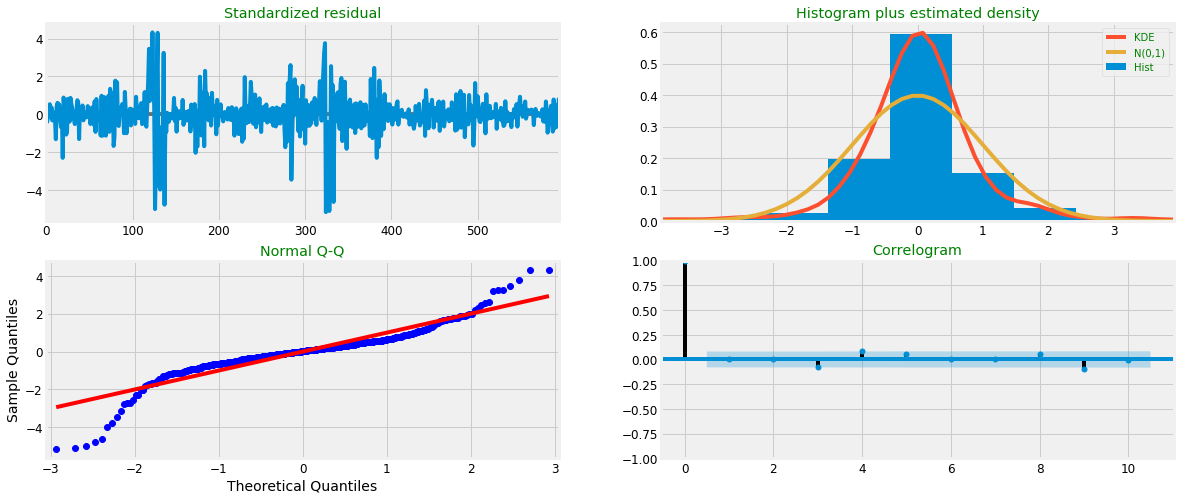

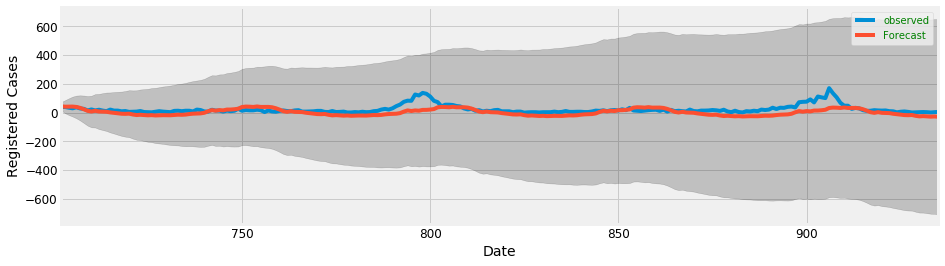

Test MAE: 25.375


In [57]:
time_series_analysis(sj_train, sj_val)

## Iquitos

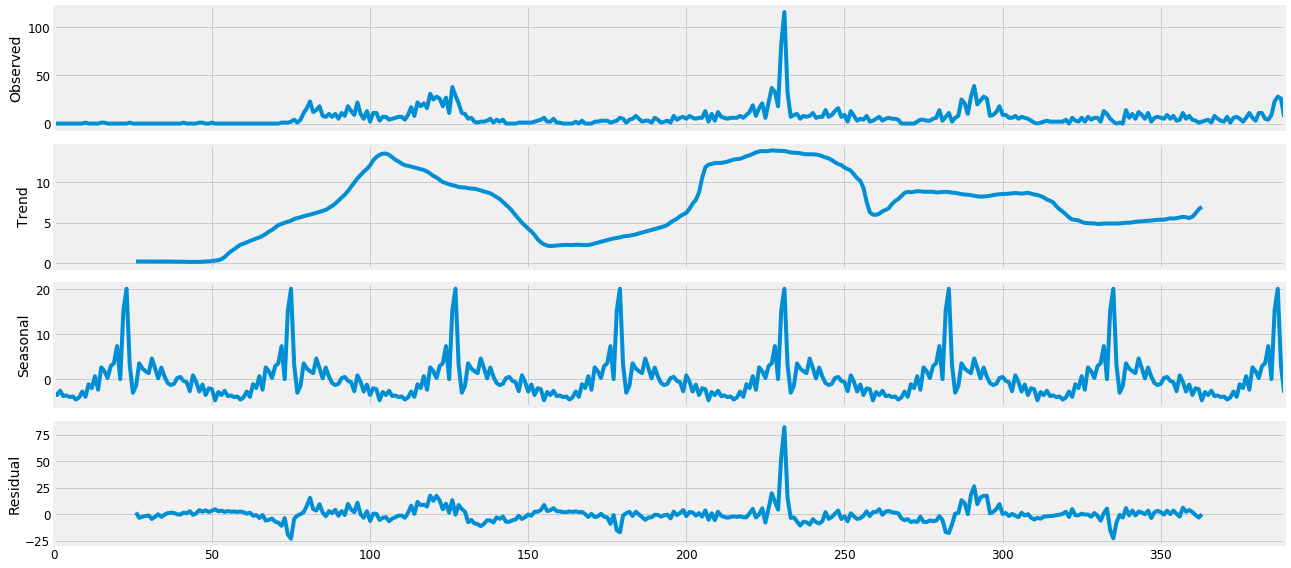

AIC:2024.9854790181182
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5821      0.045     12.906      0.000       0.494       0.670
ma.L1         -0.9314      0.031    -30.155      0.000      -0.992      -0.871
ar.S.L52      -0.2110      0.067     -3.149      0.002      -0.342      -0.080
ma.S.L52      -1.0000   1001.829     -0.001      0.999   -1964.548    1962.548
sigma2        51.5822   5.17e+04      0.001      0.999   -1.01e+05    1.01e+05


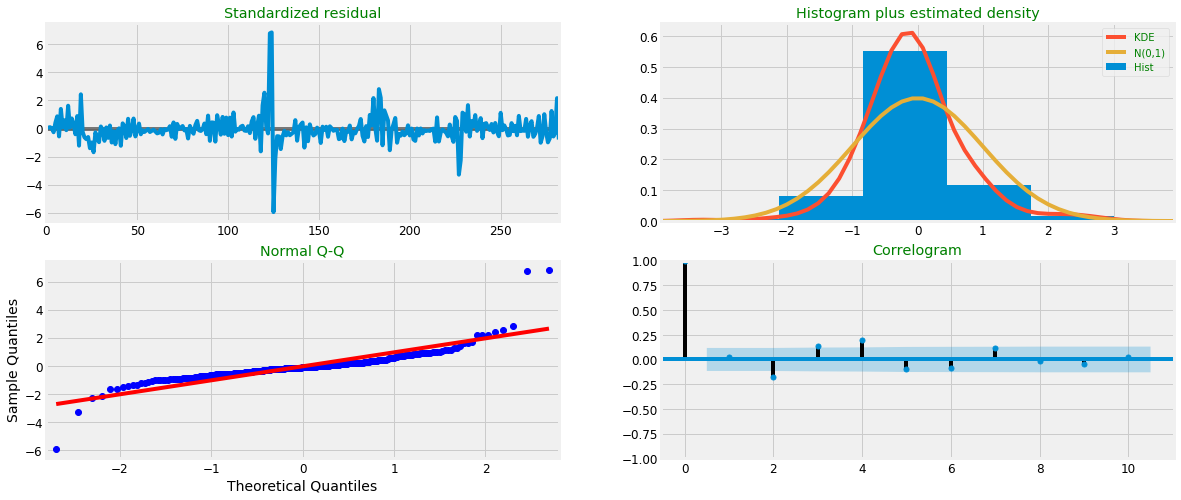

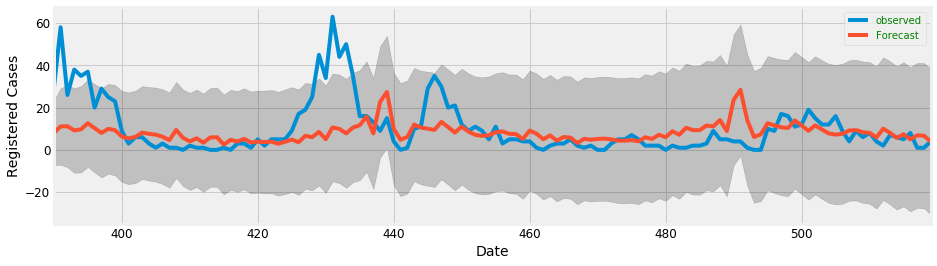

Test MAE: 7.826


In [58]:
time_series_analysis(iq_train, iq_val)

# Model with exougenous variables

In [ ]:
def treat_data(df_train, df_val):
    history = df_train['total_cases']
    history_exogenous = df_train.drop(['index', 'total_cases', 
                                       'city', 'year', 
                                       'week_start_date', 'weekofyear'], 
                                      axis=1)
    history_exogenous.fillna(method='ffill', inplace=True)
    val = df_val['total_cases']
    return history_exogenous

    
a = time_series_analysis(sj_train, sj_val)
a.head(5)


      ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  precipitation_amt_mm  \
390  0.191471  0.155414  0.176014  0.187243                 19.95   
391  0.444933  0.275850  0.356900  0.469729                 71.84   
392  0.188229  0.220829  0.233243  0.169971                 95.97   
393  0.277971  0.324929  0.221914  0.295671                102.59   
394  0.351950  0.370571  0.313800  0.402971                110.00   
..        ...       ...       ...       ...                   ...   
515  0.342750  0.318900  0.256343  0.292514                 55.30   
516  0.160157  0.160371  0.136043  0.225657                 86.47   
517  0.247057  0.146057  0.250357  0.233714                 58.94   
518  0.333914  0.245771  0.278886  0.325486                 59.67   
519  0.298186  0.232971  0.274214  0.315757                 63.22   

     reanalysis_air_temp_k  reanalysis_avg_temp_k  \
390             299.277143             300.535714   
391             296.095714             296.535714   
392         

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC:2037.1965784417134
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
ndvi_ne                                 -25.1471     14.468     -1.738      0.082     -53.504       3.210
ndvi_nw                                  14.8871     11.316      1.316      0.188      -7.291      37.065
ndvi_se                                   3.5344     12.464      0.284      0.777     -20.894      27.963
ndvi_sw                                   6.4361     12.189      0.528      0.597     -17.453      30.325
precipitation_amt_mm                     -0.0015      0.010     -0.153      0.878      -0.021       0.018
reanalysis_air_temp_k                     1.8974      6.120      0.310      0.757     -10.098      13.893
reanalysis_avg_temp_k                    -1.3223      2.076     -0.637      0.524      -5.391       2.746
reanalysis_dew_point_te

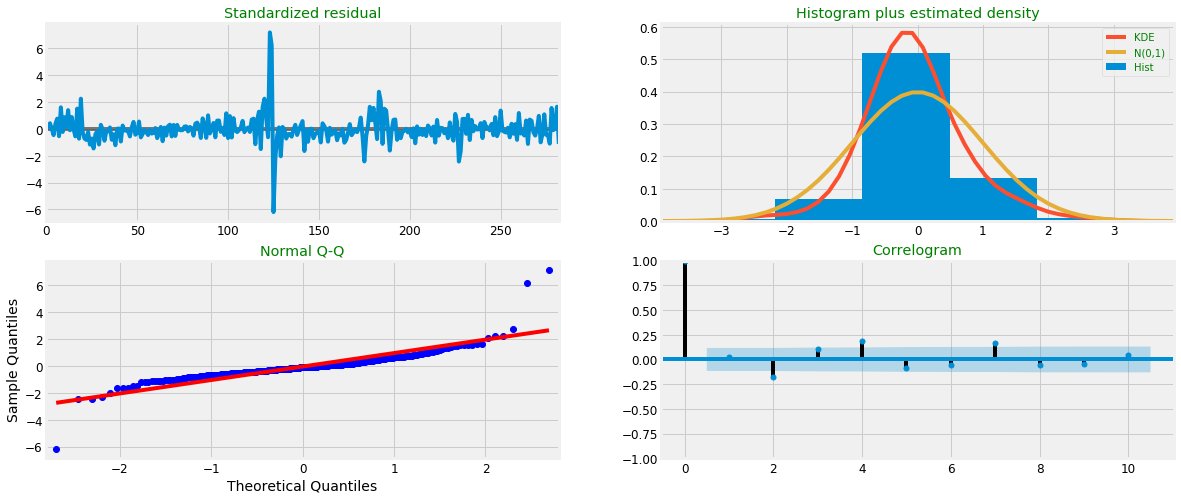

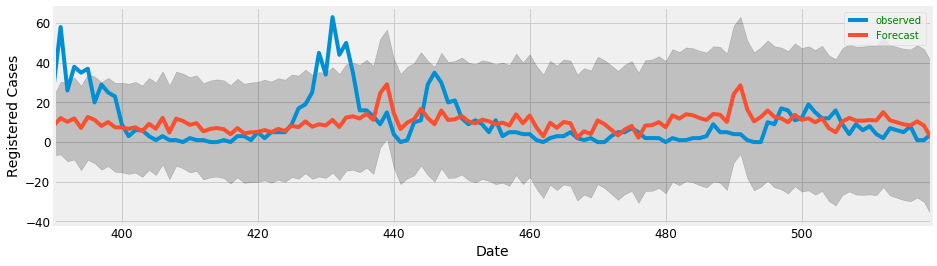

Test MAE: 8.936


In [75]:
def time_series_analysis(df_train, df_val):
    history = df_train['total_cases']
    history_exogenous = df_train.drop(['index', 'total_cases', 'city', 'year', 
                                       'week_start_date', 'weekofyear'], axis=1)
    history_exogenous.fillna(method='ffill', inplace=True)
    
    
    val = df_val['total_cases']
    val_exogenous = df_val.drop(['index', 'total_cases', 'city', 'year', 
                                 'week_start_date', 'weekofyear'], axis=1)
    val_exogenous.fillna(method='ffill', inplace=True)
    val_exogenous.fillna(method='bfill', inplace=True)
    print(val_exogenous)
    
    # Decomposition for visual analysis
    rcParams['figure.figsize'] = 18, 8
    
    # Fit a Sarimax Model with 1 year sasonality (cant get 3 years to work)
    mod = sm.tsa.statespace.SARIMAX(history, exog=history_exogenous, order=(1, 1, 1),
                                    seasonal_order=(1, 1, 1, 52),
                                    enforce_stationarity=False, enforce_invertibility=False)

    optimizer_kwargs = {}
#     optimizer_kwargs = {"maxiter": 1}
    results = mod.fit(**optimizer_kwargs)
    print('AIC:{}'.format(results.aic))
    print(results.summary().tables[1])
    results.plot_diagnostics(figsize=(18, 8))
    plt.show()
    
    # Make a prediction for the validation set and compare with ground truth
    pred_uc = results.get_forecast(steps=len(val), exog=val_exogenous)
    pred_ci = pred_uc.conf_int()
    ax = val.plot(label='observed', figsize=(14, 4))
    pred_uc.predicted_mean.plot(label='Forecast')
    ax.fill_between(pred_ci.index[:],
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Registered Cases')
    plt.legend()
    plt.show()

    predictions = pred_uc.predicted_mean.values
    error = mean_absolute_error(val, predictions)
    print('Test MAE: %.3f' % error)

    
time_series_analysis(iq_train, iq_val)

     ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  precipitation_amt_mm  \
702  0.08920  0.000350  0.094650  0.088114                 96.70   
703  0.08920  0.163500  0.137717  0.124800                 79.96   
704  0.06925  0.055375  0.065486  0.074886                 97.28   
705 -0.21795  0.015000  0.128143  0.135014                390.60   
706 -0.07015 -0.037775  0.236943  0.208457                 16.20   
..       ...       ...       ...       ...                   ...   
931  0.07785 -0.039900  0.310471  0.296243                 27.19   
932 -0.03800 -0.016833  0.119371  0.066386                  3.82   
933 -0.15520 -0.052750  0.137757  0.141214                 16.96   
934  0.00180 -0.052750  0.203900  0.209843                  0.00   
935 -0.03700 -0.010367  0.077314  0.090586                  0.00   

     reanalysis_air_temp_k  reanalysis_avg_temp_k  \
702             300.952857             301.114286   
703             300.162857             300.235714   
704             300.0542

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC:4997.228925374627
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
ndvi_ne                                 -15.2925      7.215     -2.120      0.034     -29.433      -1.152
ndvi_nw                                  15.1438     10.034      1.509      0.131      -4.522      34.809
ndvi_se                                  29.9838     16.307      1.839      0.066      -1.977      61.944
ndvi_sw                                 -28.7639     17.590     -1.635      0.102     -63.239       5.711
precipitation_amt_mm                     -0.0046      0.008     -0.586      0.558      -0.020       0.011
reanalysis_air_temp_k                    11.7987     30.313      0.389      0.697     -47.614      71.211
reanalysis_avg_temp_k                    -2.6274      5.179     -0.507      0.612     -12.778       7.523
reanalysis_dew_point_tem

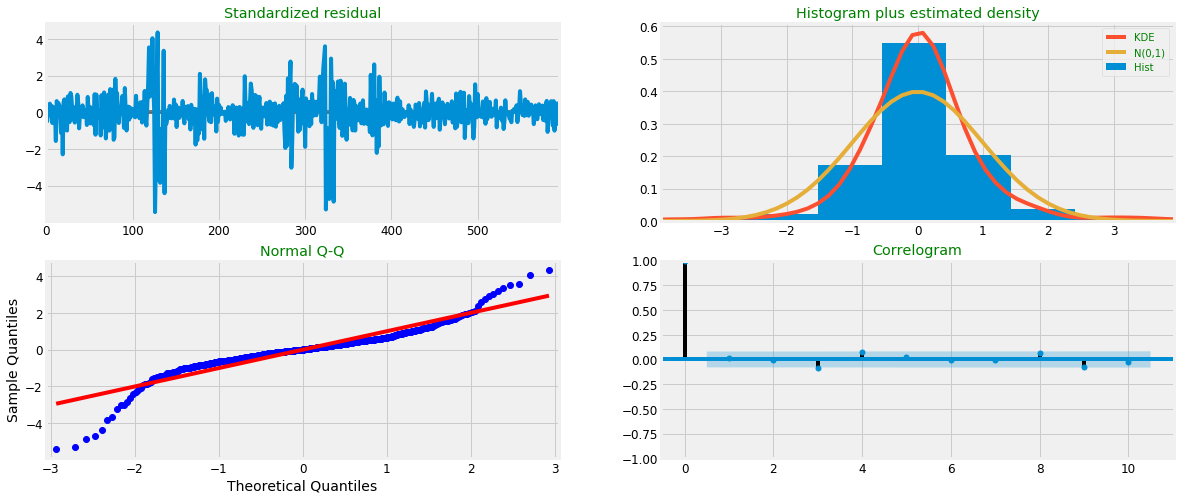

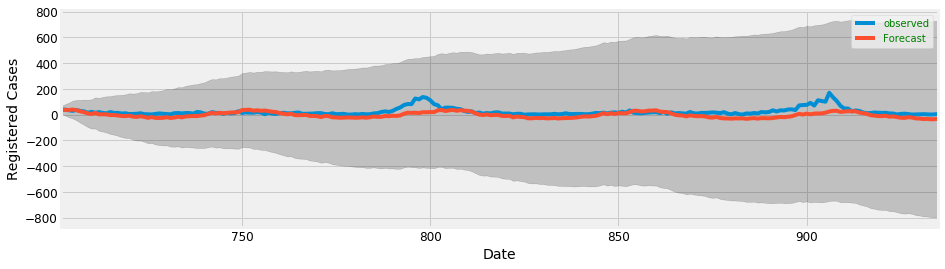

Test MAE: 27.737


In [76]:
time_series_analysis(sj_train, sj_val)